In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import peaky

In [3]:
import seaborn as sb

In [4]:
from functools import partial

In [5]:
sb.set_context("talk")
sb.set_style("whitegrid")

In [6]:
bg = peaky.Spectrum.load("data/bg.txt", live=3589.4, real=3600., label="background")
ba133 = peaky.Spectrum.load("data/ba133.txt", live=1195.4, real=1200., label="ba-133")
co60 = peaky.Spectrum.load("data/co60.txt", live=1195.4, real=1200., label="co-60")
cs137 = peaky.Spectrum.load("data/cs137.txt", live=1195.94, real=1200., label="cs-137")
fg = peaky.Spectrum.load("data/3m.txt", live=1165.484, real=1800., label="source")

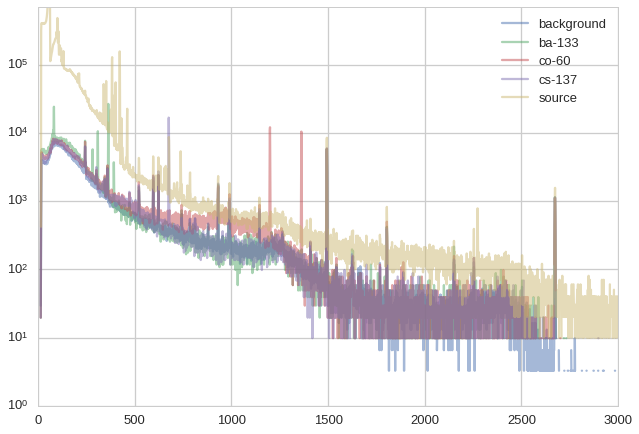

In [7]:
figure()

m = 0
for spec in [bg, ba133, co60, cs137, fg]:
    spec.plot(scale=11695.484 / spec.live, alpha=0.5)
    
    m_c = max(spec.counts)
    m = m_c if m_c > m else m
    
legend()
xlim([0, 3000])
ylim([1, 1.1 * m])

show()

In [30]:
peak_data = {
    "ba-133": {
        # 81: (.3406, (30, 140), (77, 86)),
        81: (.3406, (20, 160), (81, 85)),
        276: (.07164, (250, 303), (280, 285)),
        303: (.1833, (290, 330), (306, 312)),
        356: (.6205, (330, 380), (360, 367)),
        # 383: (.0003, (380, 410), (389, 396)),
    },
    "co-60": {
        1173: (.9985, (1150, 1300), (1196, 1203)),
        1332: (.999826, (1250, 1450), (1357, 1365)),
    },
    "cs-137": {
        661: (.899, (625, 725), (673, 680)),
    },
    "bg": {
        1460: (None, (1450, 1550), (1489, 1497)),
        2614: (None, (2600, 2750), (2667, 2678)),
    }
}

peak_dict = {
    "ba-133": ba133,
    "co-60": co60,
    "cs-137": cs137,
    "bg": bg,
}

In [31]:
peak_data_a = {
    "ba-133": {
        81: 2371,
        276: 813,
        303: 1611,
        356: 4558,
        # 383: (.0003, (380, 410), (389, 396)),
    },
    "co-60": {
        1173: 3175,
        1332: 2882,
    },
    "cs-137": {
        661: 4233,
    },
    "bg": {
        1460: None,
        2614: None,
    }
}

# Energy Calibration

In [32]:
peak_fits = {x: [] for x in peak_data.keys()}

peak_points = []
for element, lines in peak_data.iteritems():
    _spec = peak_dict[element]
    for energy, (_, (l, u), (ll, uu)) in lines.iteritems():
        _data = _spec[(l, u)]
        f = peaky.PeakFitter(
            _data[:, 0],
            _data[:, 1],
            ll,
            uu
        )
        f.fit()
        peak_fits[element].append((energy, f))
        
        peak_points.append((energy, f.centroid))
        
peak_points = array(peak_points)
peak_points = peaky.sort_fst_col(peak_points)

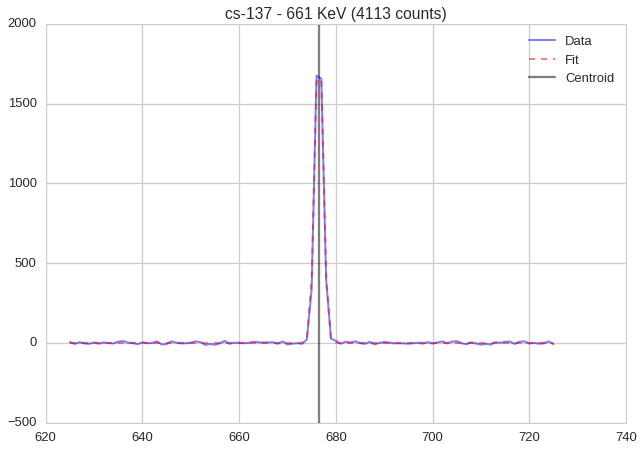

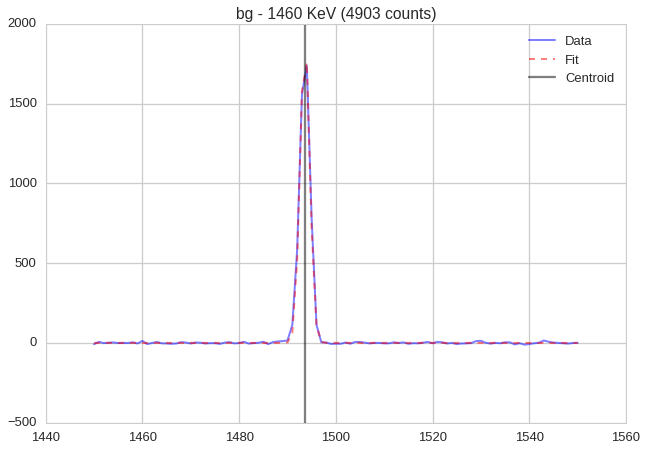

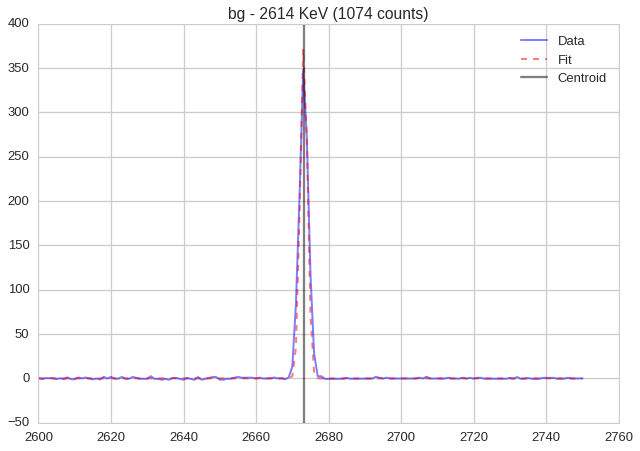

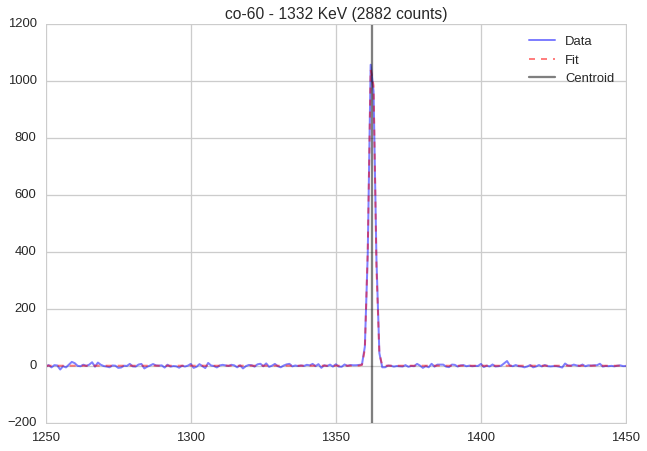

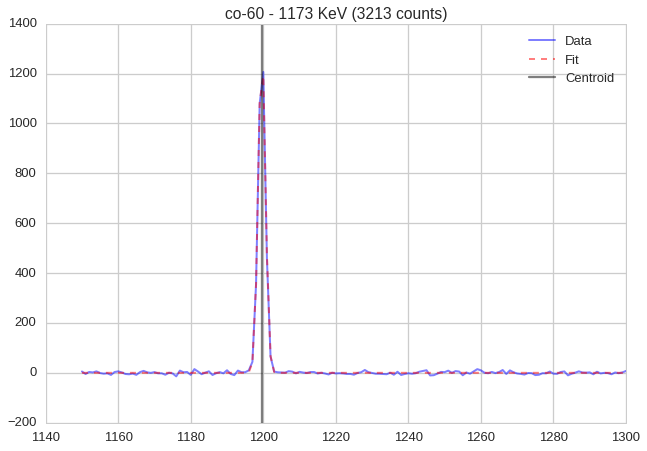

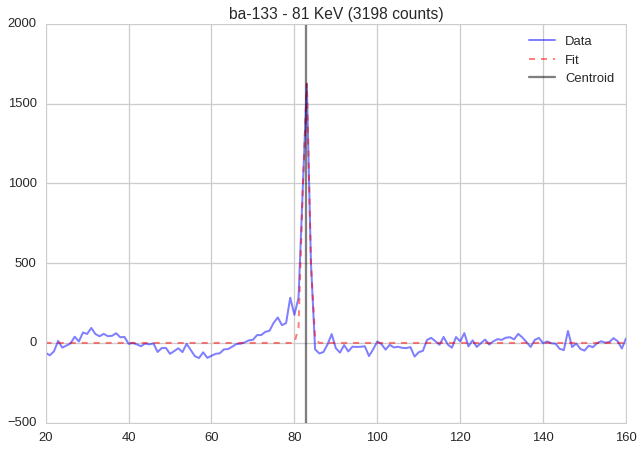

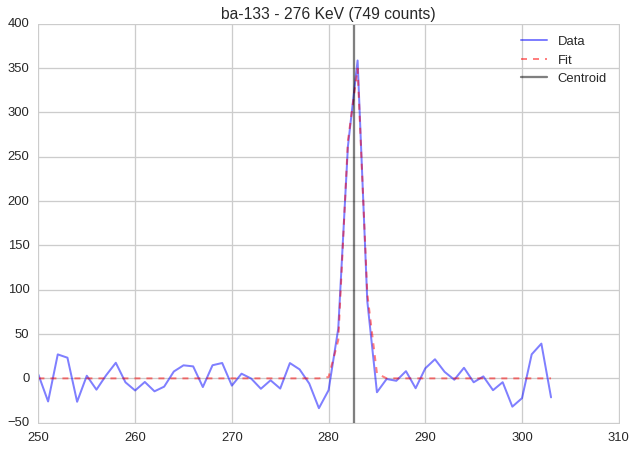

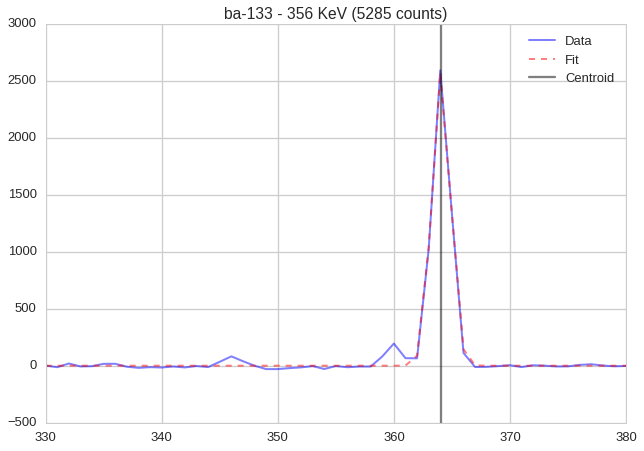

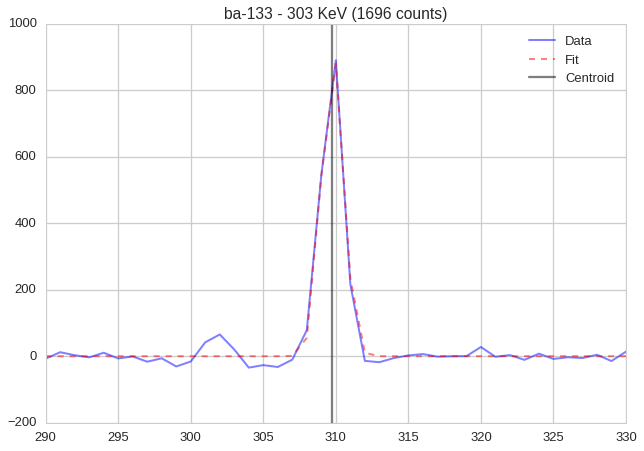

In [33]:
for el, peaks in peak_fits.iteritems():
    for energy, peak in peaks:
        figure()
        peak.plot(baseline=False)
        title("{} - {} KeV ({} counts)".format(el, energy, int(peak.area[0])))
        show()

In [12]:
energy_cal_coeff = polyfit(peak_points[:, 0], peak_points[:, 1], deg=2)

In [13]:
def eval_energy_cal(coefs, X):
    return polyval(coefs, X)

In [14]:
calibration = partial(eval_energy_cal, energy_cal_coeff)

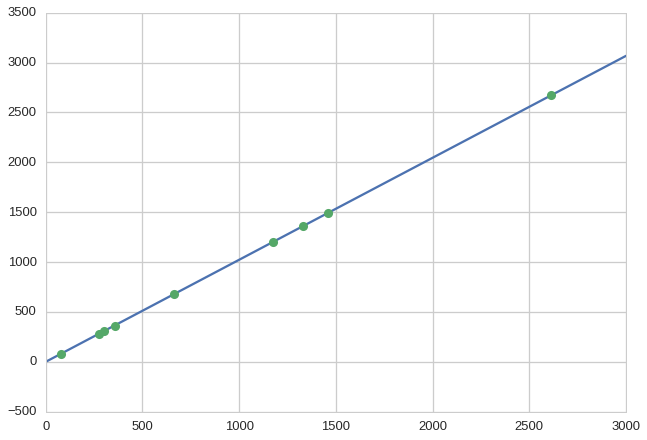

In [15]:
figure()
plot(linspace(0, 3000), calibration(linspace(0, 3000)))
plot(peak_points[:, 0], peak_points[:, 1], 'o')
show()

# Efficiency calibration

In [16]:
SRC_ACT = 20 * 3.7e4 # Bq

In [17]:
dia = 6.5 # cm
hei = 5.0 # cm
dis = 369.19 # cm

aread = pi * (dia / 2.) ** 2
areas = 4. * pi * dis ** 2

eff_geo = aread / areas

In [18]:
def calc_peak_eff(counts, dwell, act, branch):
    return counts / (act * branch * dwell * eff_geo)

In [19]:
eff_cal_points = []

for el, fits in peak_fits.iteritems():
    for energy_k, fit in fits:
        br, _, _ = peak_data[el][energy_k]
        a = peak_data_a[el][energy_k]
        
        if br is not None:
            eff = calc_peak_eff(
                #a,
                fit.area[0],
                peak_dict[el].live,
                SRC_ACT,
                br,
            )
            
            cent = calibration(fit.centroid)
            #cent = energy_k
            
            eff_cal_points.append((cent, eff))
            print(fit.fit_params)
            
eff_cal_points = peaky.sort_fst_col(array(eff_cal_points))

[  1.65451538e+03   6.76508097e+02   1.18762342e+00]
[  1.14709864e+03   1.36244570e+03   1.00000000e+00]
[  1.28300482e+03   1.19959343e+03   1.01031972e+00]
[  1.33496373e+03   8.27820838e+01   1.19994285e+00]
[ 304.44520233  282.66983484    1.2495798 ]
[  2.06402903e+03   3.64079270e+02   1.25189066e+00]
[ 687.54930851  309.76672488    1.34367801]


In [20]:
eff_cal_points

array([[  8.46752718e+01,   6.69153767e-01],
       [  2.89187020e+02,   6.10399743e-01],
       [  3.16909424e+02,   5.39937878e-01],
       [  3.72474790e+02,   4.96998518e-01],
       [  6.92085818e+02,   2.66893024e-01],
       [  1.22710231e+03,   1.87775085e-01],
       [  1.39364518e+03,   1.68207012e-01]])

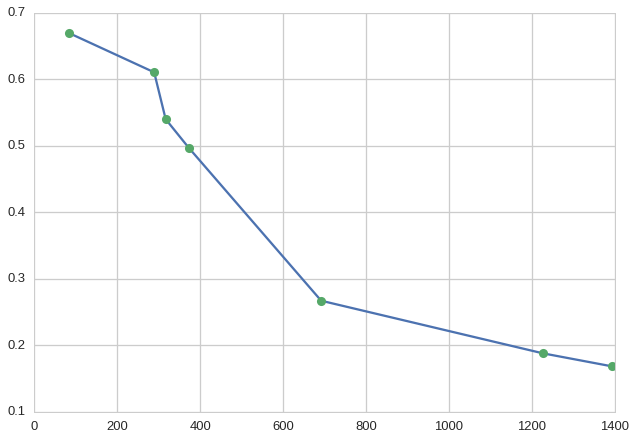

In [21]:
plot(eff_cal_points[:, 0], eff_cal_points[:, 1])
plot(eff_cal_points[:, 0], eff_cal_points[:, 1], 'o')
show()